# Import Libraries

In [35]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Data Transformations

In [36]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [37]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders

In [38]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


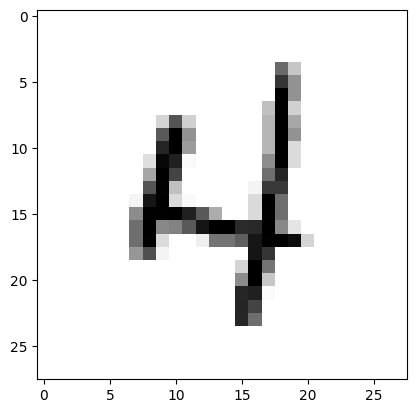

In [39]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

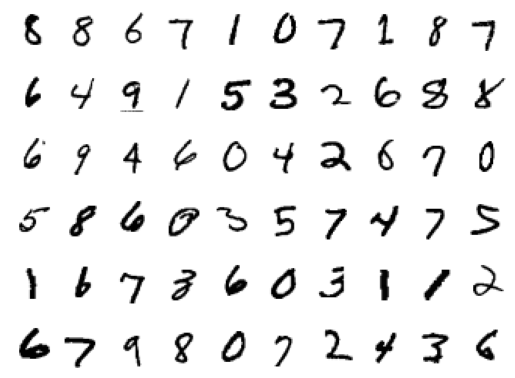

In [40]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [42]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200

# Training and Testing

In [43]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [44]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 25
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1166752502322197 Batch_id=468 Accuracy=93.03: 100%|██████████| 469/469 [00:27<00:00, 16.97it/s]



Test set: Average loss: 0.0945, Accuracy: 9716/10000 (97.16%)

EPOCH: 1


Loss=0.040734317153692245 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]



Test set: Average loss: 0.0502, Accuracy: 9853/10000 (98.53%)

EPOCH: 2


Loss=0.0811348482966423 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:20<00:00, 22.65it/s]



Test set: Average loss: 0.0401, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.013636913150548935 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:20<00:00, 23.22it/s]



Test set: Average loss: 0.0415, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.012073826044797897 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 0.0427, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.018479736521840096 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:22<00:00, 20.50it/s]



Test set: Average loss: 0.0376, Accuracy: 9881/10000 (98.81%)

EPOCH: 6


Loss=0.0206685159355402 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s]



Test set: Average loss: 0.0398, Accuracy: 9871/10000 (98.71%)

EPOCH: 7


Loss=0.013112988322973251 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0357, Accuracy: 9879/10000 (98.79%)

EPOCH: 8


Loss=0.013563357293605804 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:20<00:00, 23.01it/s]



Test set: Average loss: 0.0322, Accuracy: 9896/10000 (98.96%)

EPOCH: 9


Loss=0.007222664076834917 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0428, Accuracy: 9862/10000 (98.62%)

EPOCH: 10


Loss=0.08571788668632507 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.52it/s]



Test set: Average loss: 0.0313, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.04683302342891693 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]



Test set: Average loss: 0.0418, Accuracy: 9869/10000 (98.69%)

EPOCH: 12


Loss=0.00836964976042509 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:20<00:00, 22.85it/s]



Test set: Average loss: 0.0318, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.05353965237736702 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]



Test set: Average loss: 0.0259, Accuracy: 9917/10000 (99.17%)

EPOCH: 14


Loss=0.013476545922458172 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 15


Loss=0.054157763719558716 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:22<00:00, 20.65it/s]



Test set: Average loss: 0.0302, Accuracy: 9908/10000 (99.08%)

EPOCH: 16


Loss=0.0014062122208997607 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:20<00:00, 22.63it/s]



Test set: Average loss: 0.0279, Accuracy: 9909/10000 (99.09%)

EPOCH: 17


Loss=0.01769462414085865 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:20<00:00, 22.44it/s]



Test set: Average loss: 0.0246, Accuracy: 9912/10000 (99.12%)

EPOCH: 18


Loss=0.003133186139166355 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:21<00:00, 21.36it/s]



Test set: Average loss: 0.0262, Accuracy: 9908/10000 (99.08%)

EPOCH: 19


Loss=0.02752520702779293 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99.06%)

EPOCH: 20


Loss=0.001462404034100473 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.0260, Accuracy: 9908/10000 (99.08%)

EPOCH: 21


Loss=0.0008062077104113996 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0273, Accuracy: 9904/10000 (99.04%)

EPOCH: 22


Loss=0.0382014662027359 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:21<00:00, 21.70it/s]



Test set: Average loss: 0.0284, Accuracy: 9909/10000 (99.09%)

EPOCH: 23


Loss=0.024459803476929665 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]



Test set: Average loss: 0.0260, Accuracy: 9916/10000 (99.16%)

EPOCH: 24


Loss=0.00807399582117796 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:20<00:00, 23.37it/s]



Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)



Text(0.5, 1.0, 'Test Accuracy')

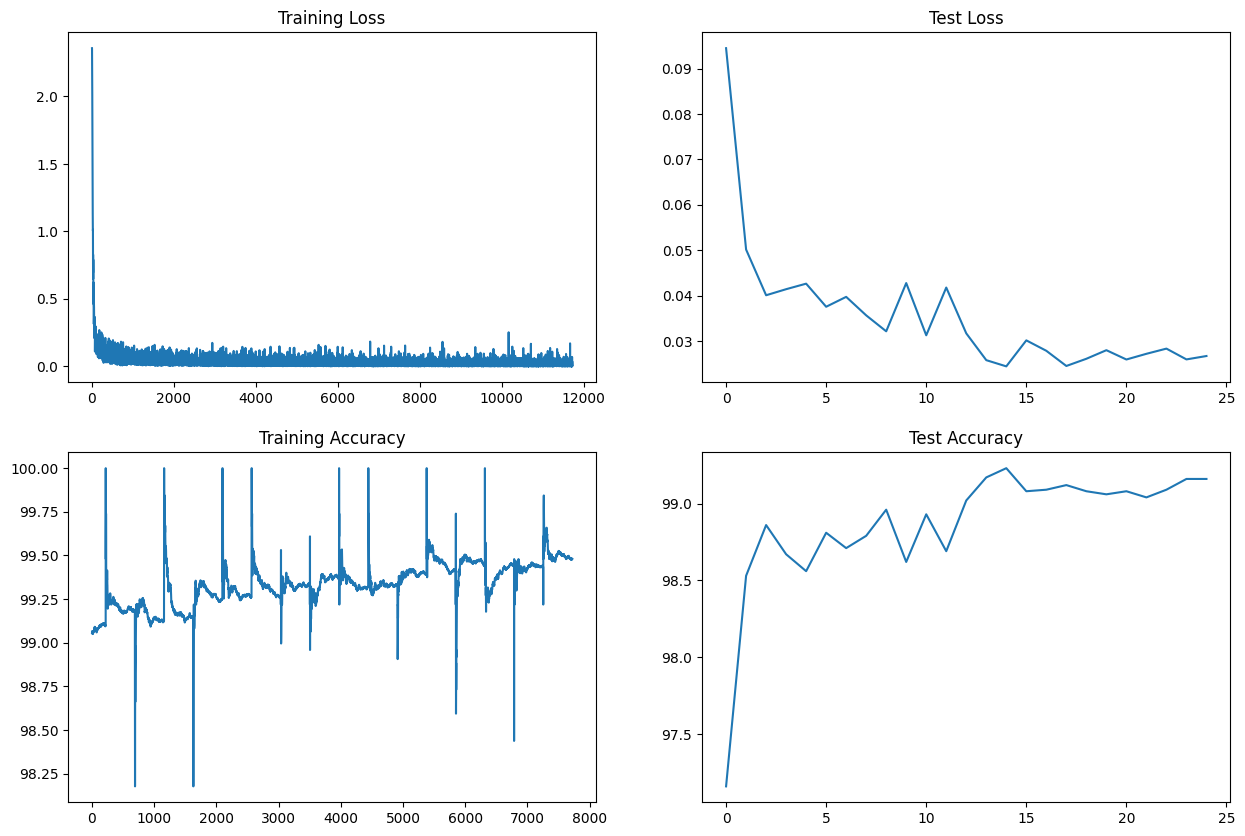

In [45]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Target
  1. Add Dropout

# Result
  1. Parameters: 10.9k
  2. Our Best Train accuracy : 99.48%
  3. Our Best Test accuracy : 99.23%

# Analysis
  1. We can see some overfitting between train and test
  2. But after adding dropout the overfitting difference gets reduced